In [1]:
#importing all the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform

# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# --- DBSCAN (with distance-based eps tuning) ---
from sklearn.neighbors import NearestNeighbors

In [6]:
df = pd.read_csv("./dataset/DM1_game_dataset.csv")
# Select numeric columns and drop missing values
df_num = df.select_dtypes(include=['float64', 'int64']).dropna()

X = df_num.values

# min-max, fit and transform directly
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

## 1. K-Means

In [ ]:
kmeans = KMeans(n_clusters=3, n_init=10, max_iter=100, random_state=94)
kmeans.fit(X_minmax)

KMeans(max_iter=100, n_clusters=3, n_init=10, random_state=94)

In [10]:
# labels
labels = kmeans.labels_
labels

array([1, 1, 1, ..., 1, 2, 1], dtype=int32)

In [11]:
# centroids
centroids = kmeans.cluster_centers_
centroids

array([[ 1.88189284e-01,  9.95532162e-01,  5.89105502e-01,
         6.00575902e-01,  1.97741608e-01,  3.44568467e-03,
         6.16674878e-01,  1.32281098e-01,  8.83948657e-03,
         5.06973577e-03,  1.76666200e-02,  7.33714770e-03,
         5.47047961e-03,  5.25452561e-03,  3.25207754e-03,
         5.25452561e-03,  4.05129019e-01,  3.21678092e-03,
         0.00000000e+00,  5.23083390e-04,  4.75320895e-03,
         1.03528969e-02,  1.37356094e-01,  5.83564907e-02,
         9.71297473e-01,  9.97680932e-01,  9.97783378e-01,
         9.45327601e-01,  9.93285041e-01,  7.25035319e-02,
         9.99610332e-01,  9.98826723e-01,  5.63715760e-02,
         3.09646685e-02,  1.00000000e+00,  2.38189758e-03,
         6.74870981e-03,  2.38189758e-03,  3.96982930e-04,
         1.19094879e-03],
       [ 3.44608901e-01,  9.92992504e-01,  3.59424895e-01,
         3.81314917e-01,  2.25400862e-01,  6.03411209e-03,
         3.62964706e-01,  1.24987169e-01,  2.28932683e-02,
         1.10383658e-02,  1.89

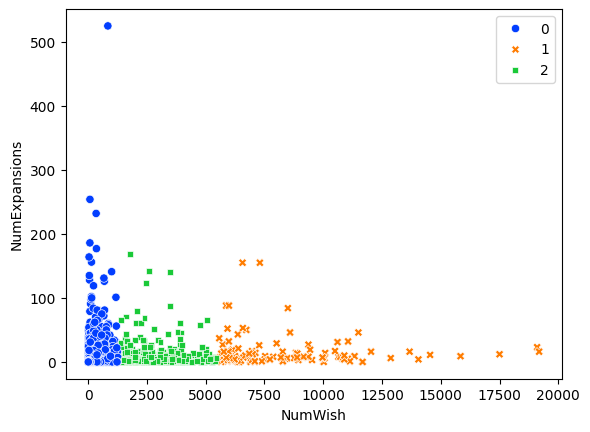

In [18]:
X_2 = df["NumWish"]
X_2_minmax = scaler.fit_transform(X_2.values.reshape(-1, 1))
X_3 = df["NumUserRatings"]
X_3_minmax = scaler.fit_transform(X_3.values.reshape(-1, 1))
kmeans_2 = KMeans(n_clusters=3, n_init=10, max_iter=100, random_state=94)
kmeans_2.fit(X_2_minmax, X_3_minmax)

sns.scatterplot(data=df,
                x="NumWish",
                y="NumExpansions",
                hue=kmeans_2.labels_,
                style=kmeans_2.labels_,
                palette="bright")
plt.show()

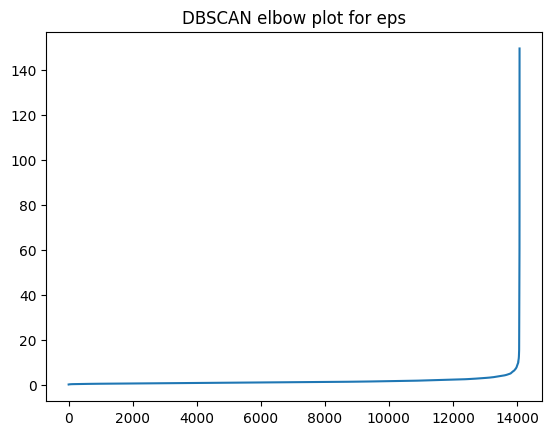

Silhouette (DBSCAN): -0.4755984717875862
{np.int64(-1): np.int64(12591), np.int64(0): np.int64(560), np.int64(1): np.int64(120), np.int64(2): np.int64(256), np.int64(3): np.int64(49), np.int64(4): np.int64(9), np.int64(5): np.int64(70), np.int64(6): np.int64(12), np.int64(7): np.int64(27), np.int64(8): np.int64(51), np.int64(9): np.int64(21), np.int64(10): np.int64(5), np.int64(11): np.int64(10), np.int64(12): np.int64(31), np.int64(13): np.int64(6), np.int64(14): np.int64(5), np.int64(15): np.int64(9), np.int64(16): np.int64(27), np.int64(17): np.int64(10), np.int64(18): np.int64(11), np.int64(19): np.int64(5), np.int64(20): np.int64(9), np.int64(21): np.int64(17), np.int64(22): np.int64(8), np.int64(23): np.int64(5), np.int64(24): np.int64(6), np.int64(25): np.int64(11), np.int64(26): np.int64(7), np.int64(27): np.int64(10), np.int64(28): np.int64(11), np.int64(29): np.int64(4), np.int64(30): np.int64(5), np.int64(31): np.int64(8), np.int64(32): np.int64(6), np.int64(33): np.int64(5)

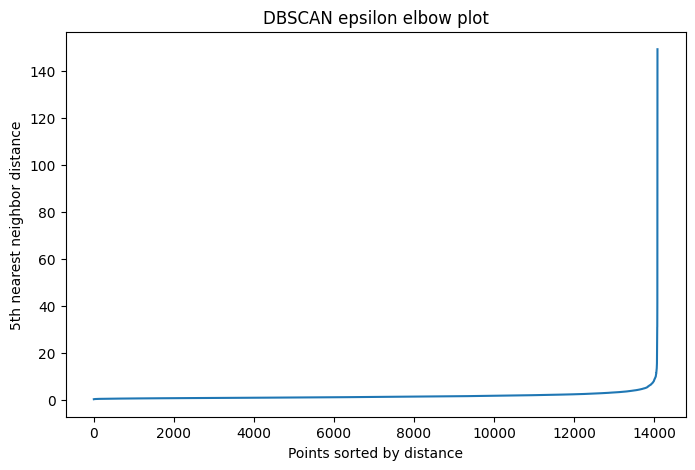

eps=8.388 | clusters=2 | noise=0.36%
Silhouette: 0.443


KeyboardInterrupt: 

In [5]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


df = pd.read_csv("./dataset/DM1_game_dataset.csv")
# Select numeric columns and drop missing values
df_num = df.select_dtypes(include=['float64', 'int64']).dropna()

# Scale features (as in the DM1 slides)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num)

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:,4])
plt.plot(distances)
plt.title("DBSCAN elbow plot for eps")
plt.show()

# Example model
db = DBSCAN(eps=0.5, min_samples=5).fit(X_scaled)
print("Silhouette (DBSCAN):", silhouette_score(X_scaled, db.labels_))

unique, counts = np.unique(db.labels_, return_counts=True)
cluster_summary = dict(zip(unique, counts))
print(cluster_summary)

# Find the elbow point
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, 4])

plt.figure(figsize=(8,5))
plt.plot(distances)
plt.title("DBSCAN epsilon elbow plot")
plt.xlabel("Points sorted by distance")
plt.ylabel("5th nearest neighbor distance")
plt.show()

eps_val = distances[14000]   # value at the elbow
db = DBSCAN(eps=eps_val, min_samples=5).fit(X_scaled)

labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
noise_ratio = list(labels).count(-1) / len(labels)

print(f"eps={eps_val:.3f} | clusters={n_clusters} | noise={noise_ratio:.2%}")

if n_clusters > 1:
    sil = silhouette_score(X_scaled, labels)
    print(f"Silhouette: {sil:.3f}")

for eps in np.linspace(eps_val*0.8, eps_val*1.2, 5):
    db = DBSCAN(eps=eps, min_samples=5).fit(X_scaled)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_ratio = list(labels).count(-1) / len(labels)
    if n_clusters > 1:
        sil = silhouette_score(X_scaled, labels)
        print(f"eps={eps:.3f} | clusters={n_clusters} | noise={noise_ratio:.1%} | silhouette={sil:.3f}")

